# Overview

Notebook ini digunakan untuk EDA untuk data [**Online Retail II UCI**](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

# Import Data

In [2]:
df = pd.read_parquet("data/preprocessed/cleaned_data.parquet") # Load Parquet
df.sample(5) # Preview data

,order_id,sku_id,sku_name,quantity,order_date,sku_price,customer_id,country,order_id_cancelled,order_id_adjustment,sku_id_no_digit
729984,559894,37327,ASSTD MULTICOLOUR CIRCLES MUG,1,2011-07-13 12:06:00,0.39,14159,UNITED KINGDOM,False,False,False
391593,C531451,22776,SWEETHEART CAKESTAND 3 TIER,-1,2010-11-08 13:02:00,9.95,13466,UNITED KINGDOM,True,False,False
920739,575748,22382,LUNCH BAG SPACEBOY DESIGN,3,2011-11-11 10:21:00,4.96,<NA>,UNITED KINGDOM,False,False,False
814306,567460,21136,PAINTED METAL PEARS ASSORTED,8,2011-09-20 12:30:00,1.69,15888,UNITED KINGDOM,False,False,False
926780,576076,85049C,ROMANTIC PINKS RIBBONS,2,2011-11-13 16:18:00,1.25,14382,UNITED KINGDOM,False,False,False


# Feature Engineering (Part I)

Akan kita coba buat beberapa fitur yang relevan terhadap penjualan, seperti:
- GMV (quantity * sku_price)
- Fitur Waktu (Jam, hari, tanggal, bulan belanja)

In [3]:
df['gmv'] = df['quantity']*df['sku_price']
df['order_hour'] = df['order_date'].dt.hour
df['order_day'] = df['order_date'].dt.day
df['order_dayofweek'] = df['order_date'].dt.dayofweek + 1 # Monday starts at 0 -> 1
df['order_month'] = df['order_date'].dt.month

# Data Exploration

## Stats Descriptive

In [4]:
df.describe()

,quantity,order_date,sku_price,customer_id,gmv,order_hour,order_day,order_dayofweek,order_month
count,1.002104e+06,1002104,1.002104e+06,775067.0,1.002104e+06,1.002104e+06,1.002104e+06,1.002104e+06,1.002104e+06
mean,1.023489e+01,2011-01-12 19:41:14.668357120,4.738350e+00,15334.108862,1.790539e+01,1.304424e+01,1.512951e+01,3.464229e+00,7.574348e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.0,-1.684696e+05,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,2010-08-01 15:36:30,1.250000e+00,13983.0,3.750000e+00,1.100000e+01,8.000000e+00,2.000000e+00,5.000000e+00
50%,3.000000e+00,2010-12-13 11:21:00,2.100000e+00,15272.0,9.900000e+00,1.300000e+01,1.500000e+01,3.000000e+00,8.000000e+00
75%,1.000000e+01,2011-07-31 13:13:00,4.130000e+00,16806.0,1.770000e+01,1.500000e+01,2.200000e+01,5.000000e+00,1.100000e+01
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.0,1.684696e+05,2.100000e+01,3.100000e+01,7.000000e+00,1.200000e+01
std,1.710926e+02,NaN,1.274008e+02,1696.790865,2.988115e+02,2.434350e+00,8.681218e+00,1.882841e+00,3.510506e+00


- Kita punya 3 tahun data (2009 - 2011) cukup untuk melihat tren tahun ke tahun
- Ada harga yang negatif?
- Quantity negatif (yang berasal dari order yang cancelled)
- sebagian besar data punya low quantity ataupun low price
- Ada right skewness (sebagian besar data punya value kecil, namun ada beberapa value ekstrim), dapat dilihat dari median yang lebih kecil dari mean

In [5]:
for col in ['order_id','sku_id','customer_id','country']:
    print(f'unique value {col}:',df[col].nunique())

unique value order_id: 48020
unique value sku_id: 4795
unique value customer_id: 5932
unique value country: 43


In [6]:
# Cek untuk sku price negatif
df[df['sku_price']<0]

,order_id,sku_id,sku_name,quantity,order_date,sku_price,customer_id,country,order_id_cancelled,order_id_adjustment,sku_id_no_digit,gmv,order_hour,order_day,order_dayofweek,order_month
152716,A506401,B,ADJUST BAD DEBT,1,2010-04-29 13:36:00,-53594.36,<NA>,UNITED KINGDOM,False,True,True,-53594.36,13,29,4,4
237486,A516228,B,ADJUST BAD DEBT,1,2010-07-19 11:24:00,-44031.79,<NA>,UNITED KINGDOM,False,True,True,-44031.79,11,19,1,7
355108,A528059,B,ADJUST BAD DEBT,1,2010-10-20 12:04:00,-38925.87,<NA>,UNITED KINGDOM,False,True,True,-38925.87,12,20,3,10
766793,A563186,B,ADJUST BAD DEBT,1,2011-08-12 14:51:00,-11062.06,<NA>,UNITED KINGDOM,False,True,True,-11062.06,14,12,5,8
766794,A563187,B,ADJUST BAD DEBT,1,2011-08-12 14:52:00,-11062.06,<NA>,UNITED KINGDOM,False,True,True,-11062.06,14,12,5,8


Untuk SKU price yang negatif, kita dapat drop data tersebut

In [7]:
df = df[df['sku_price']>0]

# Missing Value Analysis

Secara sekilas, kita dapat melihat missing value dengan:

In [8]:
df.isnull().sum()/len(df)

order_id               0.000000
sku_id                 0.000000
sku_name               0.000000
quantity               0.000000
order_date             0.000000
sku_price              0.000000
customer_id            0.225928
country                0.000000
order_id_cancelled     0.000000
order_id_adjustment    0.000000
sku_id_no_digit        0.000000
gmv                    0.000000
order_hour             0.000000
order_day              0.000000
order_dayofweek        0.000000
order_month            0.000000
dtype: float64

Pada kasus ini, setelah pengolahan data yang ada di part 1, missing value yang tersisa hanya ada di customer_id

Untuk menghandle missing value, ada beberapa hal yang bisa dicoba:
- Drop missing value (Jika tidak terlalu banyak informasi yang hilang)
- Imputasi (Perlu dicek apakah missing valuenya sistemik, ex: hanya muncul di grup tertentu)
- Ignore

**Dalam kasus ini**, karena missing value cukup banyak 22%, maka kita tidak melakukan drop missing value <br> Untuk imputasi pun juga tidak makes sense, karena ini merupakan ID <br> Jadi kita dapat ignore missing value tersebut

**Catatan**: jika anda menemukan missing value, banyak metode untuk mengimputasinya, seperti fill dengan median (numerik, ordinal), modus (nominal). Ataupun dengan imputasi multivariate seperti metode MICE

# Visualization (Part 1)

Untuk mendapatkan sense dari data, maka diperlukan visualisasi, mari kita cek distribusi dari masing masing kolom

In [9]:
# Group for categorical (ordinal)
cat_cols = ['order_hour','order_day','order_dayofweek','order_month'] 

# Numerical data
num_cols = ['quantity','sku_price','gmv']

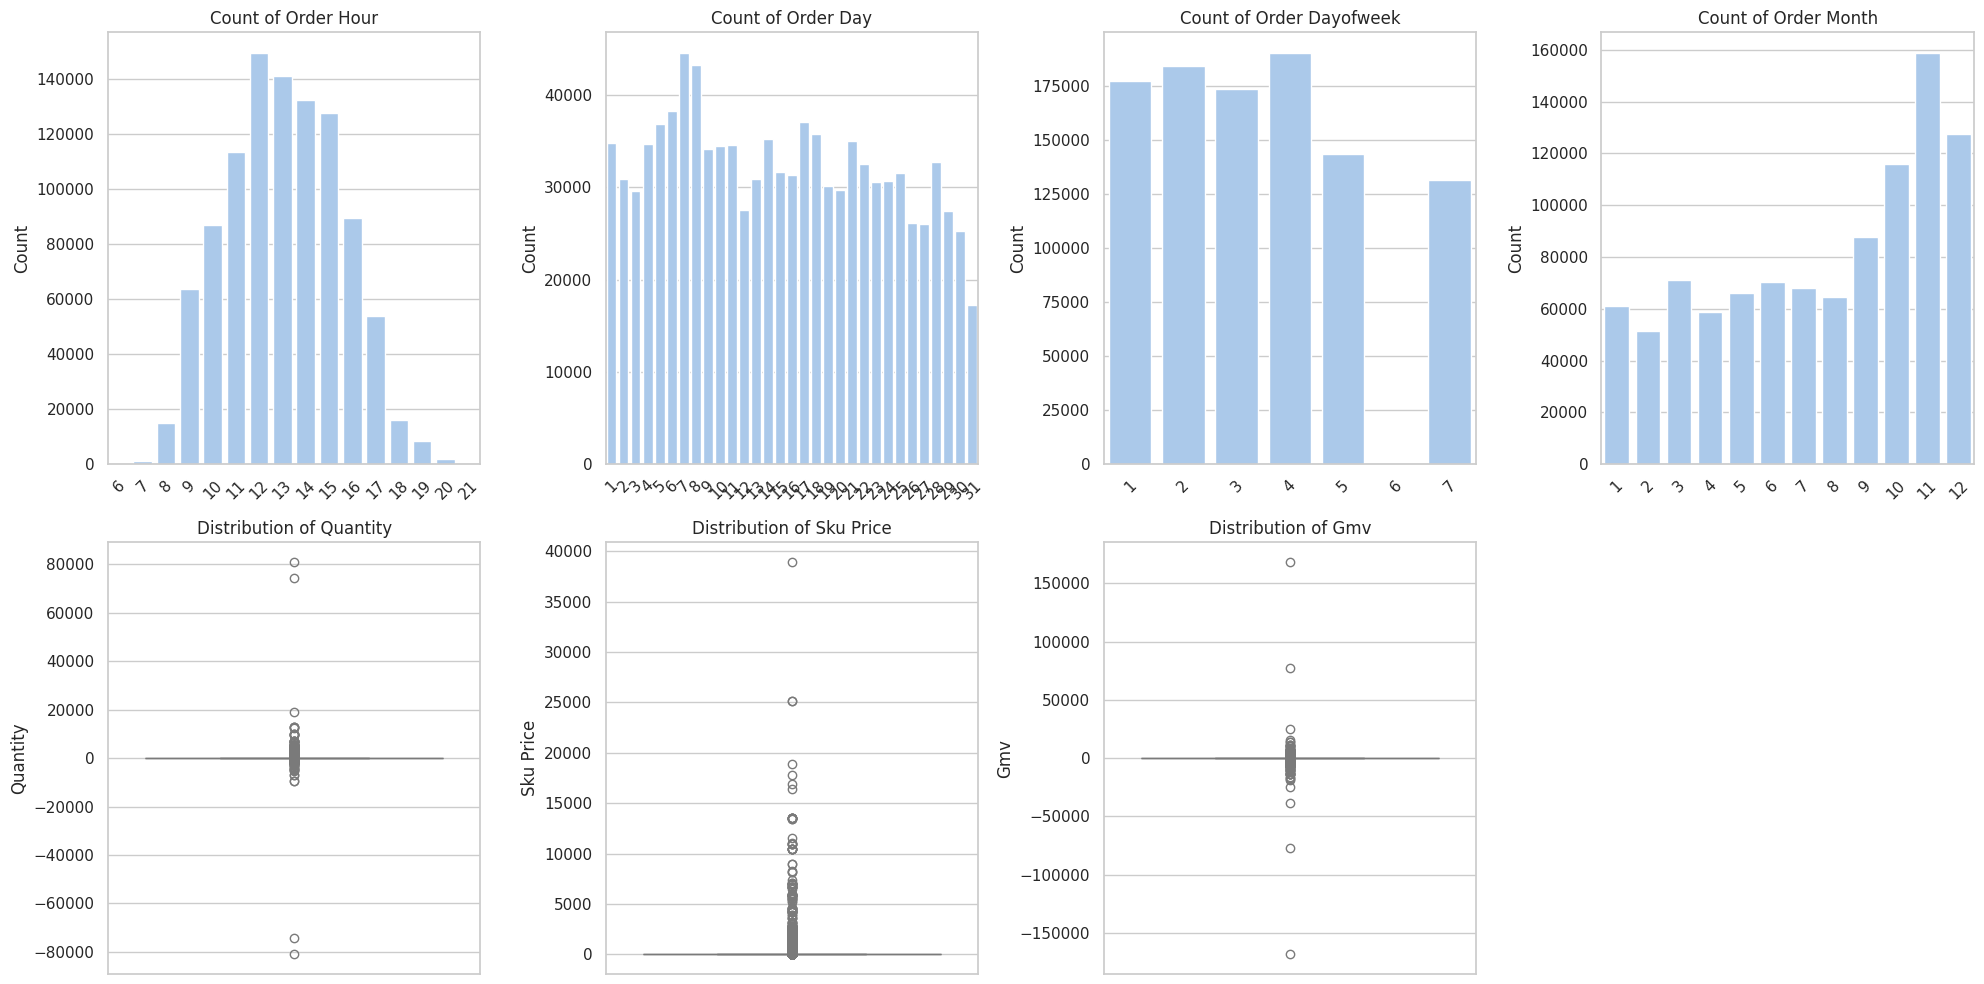

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols):
    sns.countplot(x=col, data=df, ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols):
    sns.boxplot(y=col, data=df, ax=ax)
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1]) # Delete the last subplot because it's empty
    
plt.tight_layout()
plt.show()

Key Insight:
- Kita bisa lihat 'jam buka' retail pada jam 8 pagi sampai 8 malam, dengan pembelian terbanyak di siang hari
- Untuk tanggal belanja, kebanyakan pembelian ada di awal bulan, dan perlahan menurun
- Pembelian terbanyak ada di hari kamis, dan ternyata toko ini libur saat hari sabtu
- Untuk bulan belanja, terbanyak pada akhir tahun
- Karena outlier, kita bahkan tidak dapat melihat distribusi dari quantity, price, dan gmv

Outlier tersebut dapat mempengaruhi analisa, jadi mesti kita handle

# Outlier Handling

Karena gmv merupakan produk dari quantity*price, kita cukup fokus menganalisa quantity dan price saja

Secara statistik, Outlier Detection dapat dilakukan dengan beberapa cara:
- Univariate
- Multivariate 

Univariate hanya memperhatikan kolom yang difokuskan, sedangkan Multivariate memperhatikan relasi terhadap kolom lainnya <br> Contoh simplenya: barang dengan gmv tinggi bisa saja diflag sebagai outlier dengan deteksi univariate, namun jika quantity penjualannya juga tinggi, seharusnya fair fair saja kalau gmv nya juga tinggi, tidak terdeteksi outlier secara multivariate

Contoh metode yang dapat digunakan adalah <br>
Untuk Univariate:
- Z-score (Standardize the data, kurangi mean $\mu$ dan dibagi standard deviation $\sigma$)
- IQR Bound (Hitung IQR = Quartile 3 ($Q_3$) - Quartile 1 ($Q_1$), lalu flag data yang diatas $Q_3 + k*IQR$ atau dibawah $Q_1 - k*IQR$

What works best? 
- Z-score menggunakan $\mu$ dan $\sigma$, dua *central tendency* yang tidak robust terhadap outlier, gunakan Z-score jika data anda tidak skewed (works best on approximately normal data)
- IQR Bound menggunakan percentile, yang cukup robust terhadap outlier

Untuk Multivariate:
- Gunakan metode anomaly detection seperti **Isolation Forest**, **DBScan** untuk menemukan outlier

## Outlier detection dengan IQR

In [11]:
Q1_qty, Q3_qty = df['quantity'].quantile([0.25, 0.75])
IQR_qty = Q3_qty - Q1_qty

Q1_price, Q3_price = df['sku_price'].quantile([0.25, 0.75])
IQR_price = Q3_price - Q1_price

# 2) Define lower/upper bounds
lower_qty = Q1_qty - 5 * IQR_qty
upper_qty = Q3_qty + 5 * IQR_qty

lower_price = Q1_price - 5 * IQR_price
upper_price = Q3_price + 5 * IQR_price

print(f"Quantity outlier bounds: [{lower_qty:.2f}, {upper_qty:.2f}]")
print(f" SKU Price outlier bounds: [{lower_price:.2f}, {upper_price:.2f}]\n")

# 3) Create masks for outliers
df['outlier_qty'] = (df['quantity'] < lower_qty) | (df['quantity'] > upper_qty)
df['outlier_price'] =  (df['sku_price'] < lower_price) | (df['sku_price'] > upper_price)

df['outlier_flag'] = df['outlier_qty'] | df['outlier_price']

Quantity outlier bounds: [-44.00, 55.00]
 SKU Price outlier bounds: [-13.15, 18.53]



Step selanjutnya adalah, mengecek kenapa data tersebut outlier, apakah ada tanggal tanggal tertentu?

### Previous Visualization on Outlier only

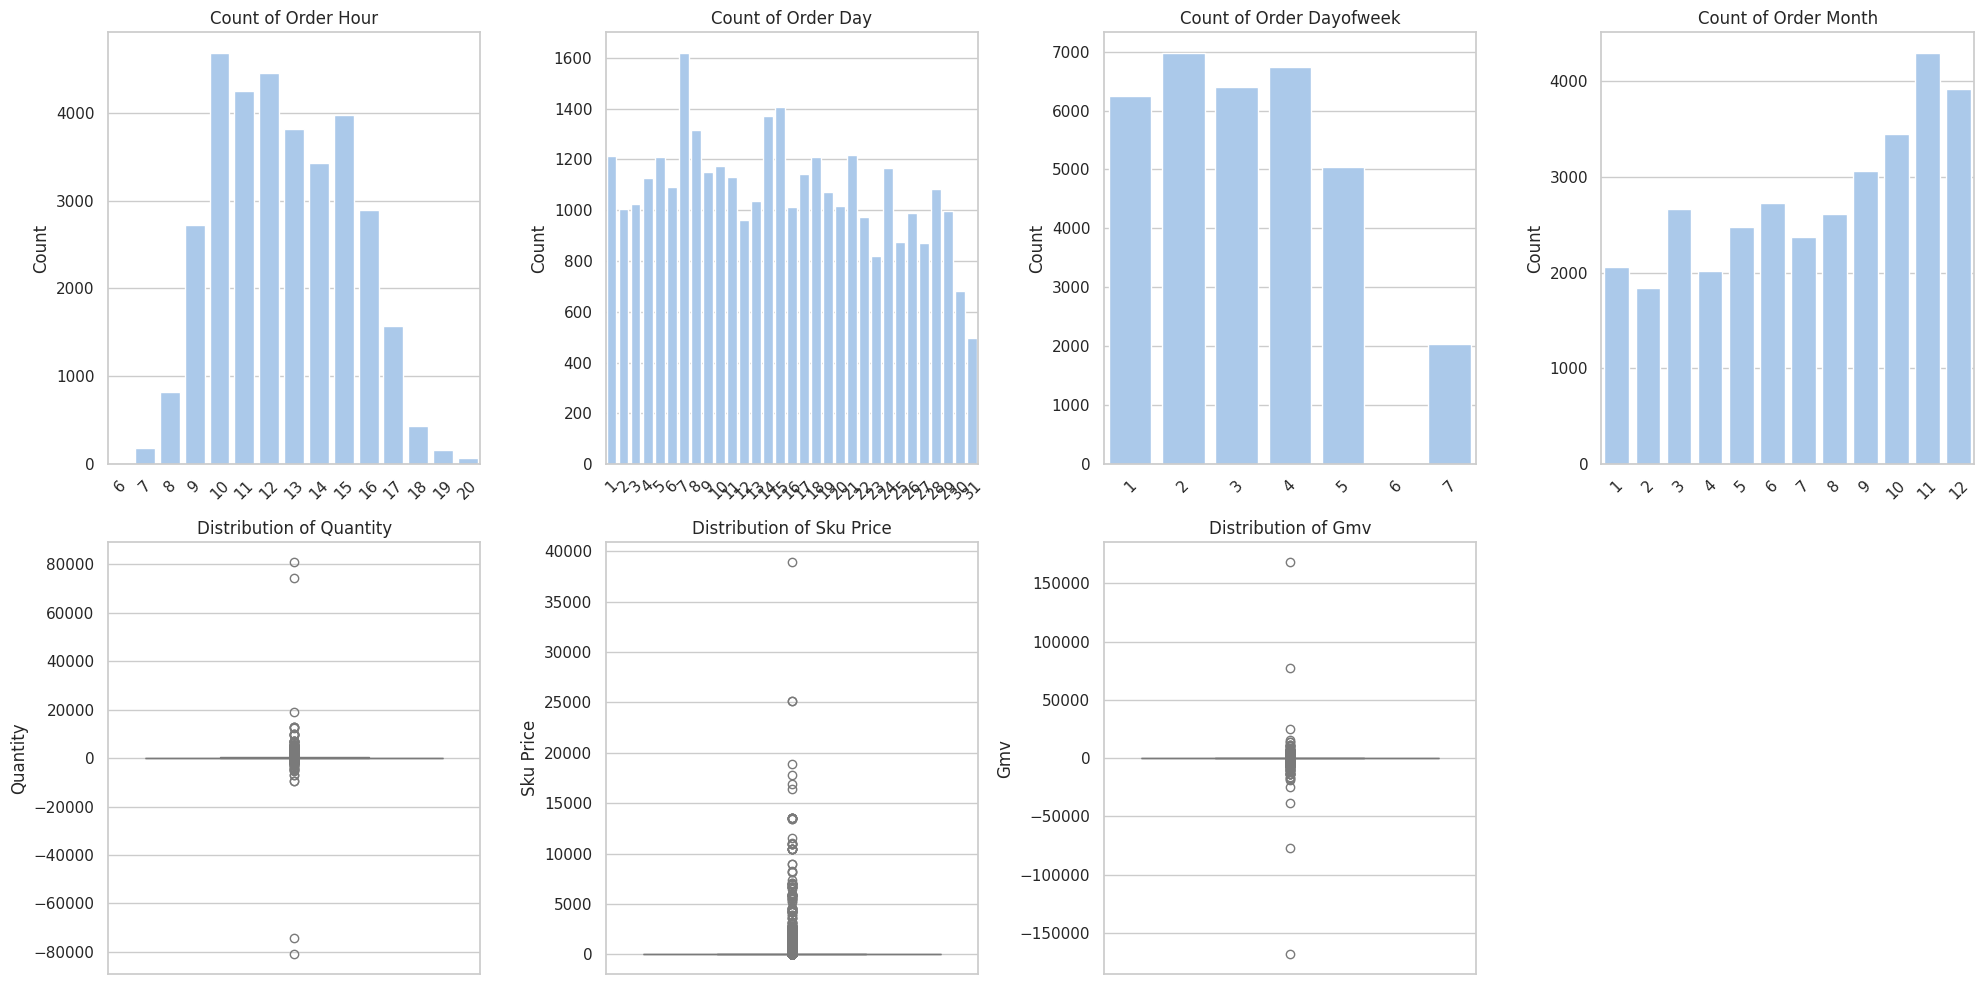

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols):
    sns.countplot(x=col, data=df[df['outlier_flag']], ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols):
    sns.boxplot(y=col, data=df[df['outlier_flag']], ax=ax)
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1]) # Delete the last subplot because it's empty
    
plt.tight_layout()
plt.show()

Tidak terlihat pattern tertentu untuk tanggal pembelian

### Previous Visualization on Non Outlier

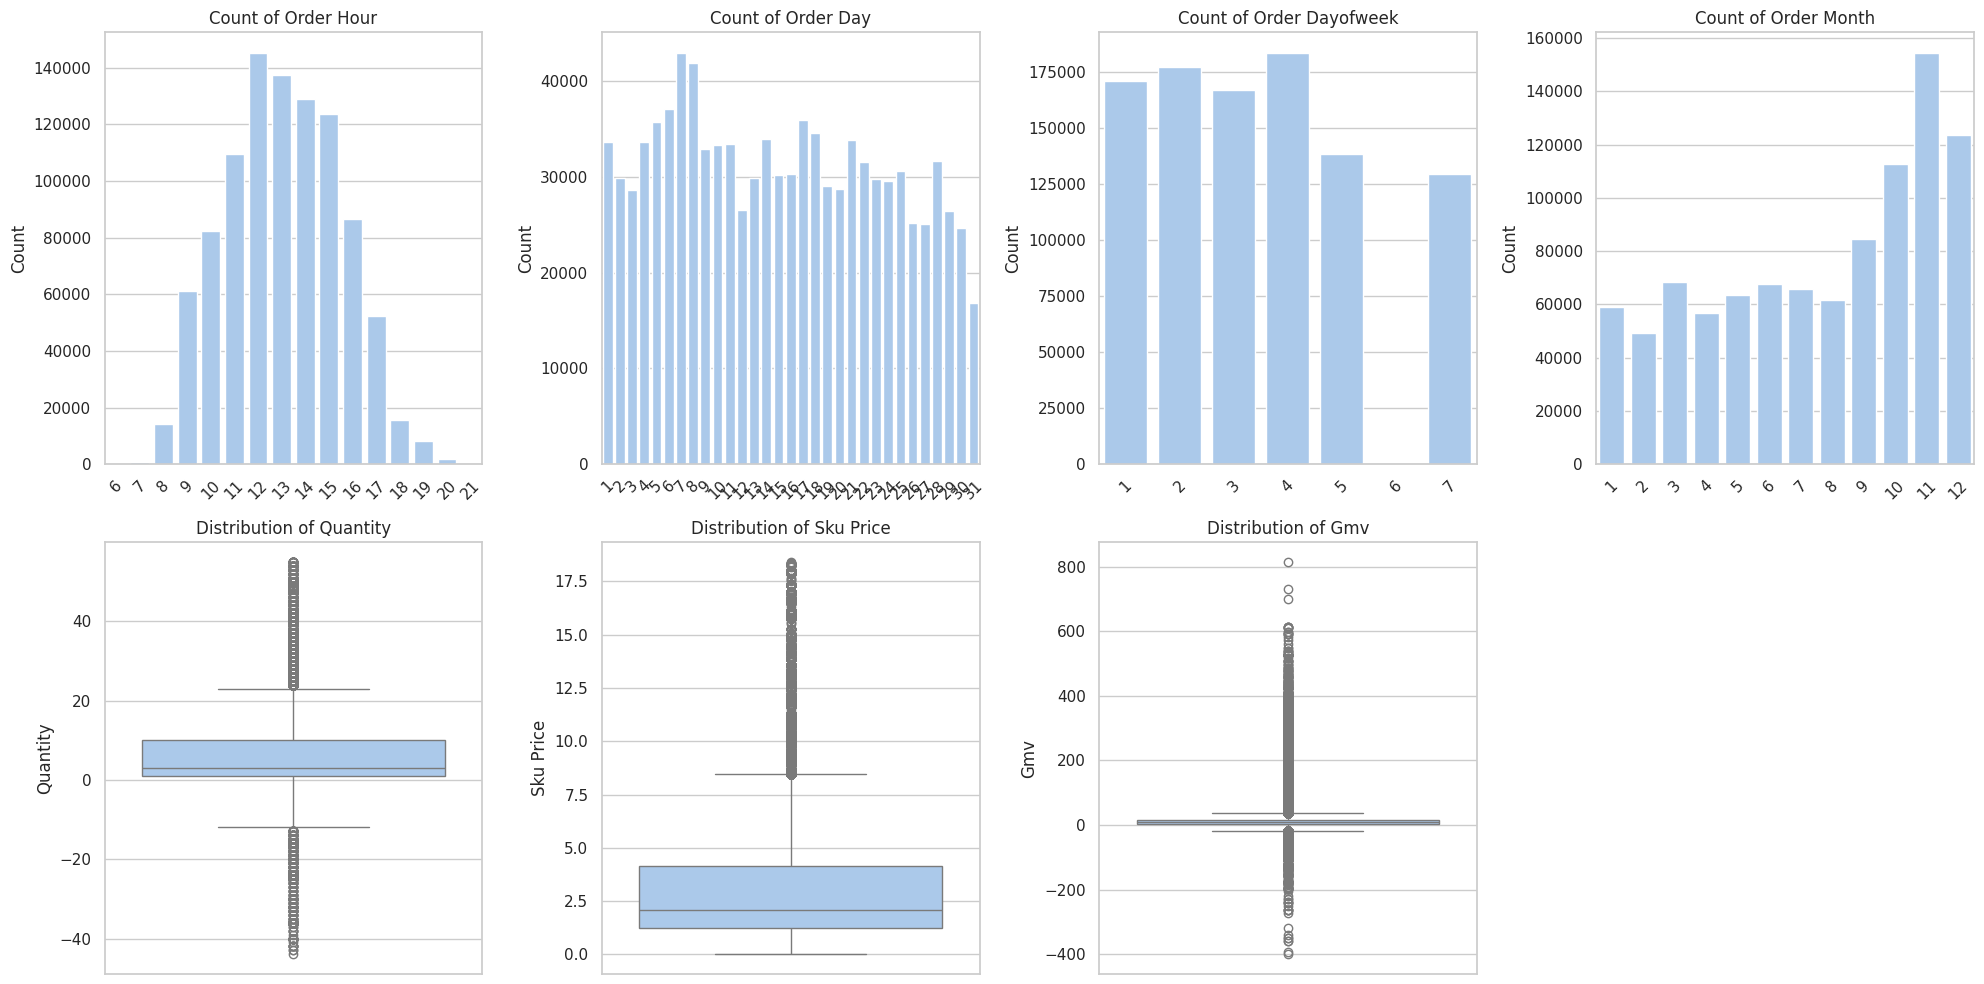

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 2 row x 4 columns untuk setiap kolom

# Row 1: row categorical, countplots
for ax, col in zip(axes[0], cat_cols):
    sns.countplot(x=col, data=df[~df['outlier_flag']], ax=ax) # Countplot
    ax.set_title(f"Count of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45) # Rotate untuk visibility

# Row 2: row numeric, boxplots
for ax, col in zip(axes[1], num_cols):
    sns.boxplot(y=col, data=df[~df['outlier_flag']], ax=ax)
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}")
    ax.set_xlabel('')
    ax.set_ylabel(col.replace('_',' ').title())

fig.delaxes(axes[1,-1]) # Delete the last subplot because it's empty
    
plt.tight_layout()
plt.show()

Setelah memfokuskan pada non-outlier, kita sedikit bisa melihat distribusi dari quantity dan sku price

## What to explore next?

Dari data ini saja, sudah banyak possibility untuk eksplorasi, misal:
- Apakah dari data outlier tersebut, dilakukan oleh customer yang sama? (Ada Bulk Buyer, bahkan fraud?)
- Apakah outlier tersebut dimunculkan karena kesalahan input?
- Apakah terdapat produk yang harganya tiba tiba naik?

## Bulk Buyer

In [14]:
high_quantity_purchase = df[df['outlier_qty']]
high_quantity_purchase_customer = high_quantity_purchase[['customer_id']].drop_duplicates()
high_quantity_purchase_customer['have_high_quantity_purchase'] = True

In [15]:
purchase_per_customer = df.groupby('customer_id').agg({'quantity':'mean'}).reset_index().rename(columns={'quantity':'average_quantity'})
purchase_per_customer = purchase_per_customer.merge(high_quantity_purchase_customer,on='customer_id',how='left')
purchase_per_customer['have_high_quantity_purchase'] = purchase_per_customer['have_high_quantity_purchase'].fillna(False)

/tmp/ipykernel_92925/1587000428.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  purchase_per_customer['have_high_quantity_purchase'] = purchase_per_customer['have_high_quantity_purchase'].fillna(False)


In [16]:
purchase_per_customer[purchase_per_customer['have_high_quantity_purchase']]

,customer_id,average_quantity,have_high_quantity_purchase
0,12346,1.133333,True
1,12347,13.157895,True
2,12348,55.041667,True
9,12355,15.514286,True
10,12356,23.894366,True
...,...,...,...
5912,18271,15.190476,True
5914,18273,35.000000,True
5920,18279,48.461538,True
5926,18285,12.083333,True


Ada customer yang biasanya secara rata rata punya 1 pembelian, namun tiba tiba punya pembelian quantity besar, namun ada juga customer yang terbiasa membeli secara grosir (bulk buyer)

Banyak *nuance* yang mesti diselidiki, apakah pembelian itu adalah barang yang murah? atau kah luxury goods? Ini dapat ditelusuri lebih lanjut

## Product Price Checking

Mari kita cek poin terakhir, mungkin outlier nya terjadi karena ada kesalahan di price

In [17]:
# Dapatkan summary min, q1, median, q3, max price per product
product_price_summary = (
    df.groupby(['sku_id','sku_name'])
      .agg(sku_price_min=('sku_price', 'min'),
           sku_price_q1=('sku_price', lambda x: x.quantile(0.25)),
           sku_price_median=('sku_price', 'median'),
           sku_price_q3=('sku_price', lambda x: x.quantile(0.75)),
           sku_price_max=('sku_price', 'max'))
      .reset_index()
)

# Dapatkan ratio nya, sebagai ukuran seberapa jauh nilai maksimum dari median
product_price_summary['max_to_median_ratio'] = product_price_summary['sku_price_max']/product_price_summary['sku_price_median']
product_price_summary.sort_values('max_to_median_ratio',ascending=False).head(10)

,sku_id,sku_name,sku_price_min,sku_price_q1,sku_price_median,sku_price_q3,sku_price_max,max_to_median_ratio
4698,PADS,PADS TO MATCH ALL CUSHIONS,0.001,0.001,0.001,0.001,36.60,36600.000000
4697,M,MANUAL,0.030,1.250,12.750,342.015,38970.00,3056.470588
3439,84016,FLAG OF ST GEORGE CAR FLAG,0.350,0.420,0.420,0.420,1157.15,2755.119048
4699,POST,POSTAGE,0.500,18.000,18.000,18.000,8142.75,452.375000
4671,BANK CHARGES,BANK CHARGES,0.001,15.000,42.120,359.440,18910.69,448.971747
106,17003,BROCADE RING PURSE,0.050,0.210,0.290,0.390,57.60,198.620690
4674,D,DISCOUNT,0.010,9.900,19.000,56.900,1867.86,98.308421
3451,84033,FLAG OF ST GEORGE,1.650,1.650,1.650,1.650,85.10,51.575758
2983,37482P,CUBIC MUG PINK POLKADOT,0.390,0.390,0.390,2.550,16.98,43.538462
2980,37479P,CUBIC MUG FLOCK PINK ON BROWN,0.390,0.390,0.390,2.550,16.98,43.538462


Nah, setelah pengolahan data tadi, sudah terlihat outlier price nya, data data ini yang perlu diperhatikan lebih. Mari kita coba buat threshold untuk adjust price

In [18]:
product_price_summary['sku_price_iqr'] = (
    product_price_summary['sku_price_q3'] - product_price_summary['sku_price_q1']
)

product_price_summary['sku_price_upper_bound'] = (
    product_price_summary['sku_price_q3'] + 1.5 * product_price_summary['sku_price_iqr']
)

In [19]:
df = df.merge(product_price_summary[['sku_id','sku_price_upper_bound']])

Selanjutnya, kita dapat men-*capping* sku price, jadi price yang lebih dari upper bound nya akan kita jadikan sesuai dengan upper boundnya

In [20]:
df['outlier_price'] = df['sku_price'] > df['sku_price_upper_bound']
df['adjusted_price'] = df.apply(lambda x: min(x['sku_price'],x['sku_price_upper_bound']),axis=1)

Karena sudah ada adjusted_price, maka GMV juga perlu di update

In [21]:
df['adjusted_gmv'] = df['sku_price']*df['quantity']

Untuk quantity, kita tidak dapat menerapkan logic yang serupa (tidak bisa membuat adjusted quantity)

In [22]:
# Update flag outlier
df['outlier_flag'] = df['outlier_price'] | df['outlier_qty']

Setelah melakukan outlier handling, akhirnya kita bisa lanjut analisa yang lebih dalam dan menemukan insight insight menarik

# Visualization (Part 2)